In [141]:
import pandas as pd
from matplotlib import pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from scipy.stats import randint, uniform
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
from sklearn.metrics import classification_report, accuracy_score



EXAMEN FINAL



In [142]:
path = '../resources/examen_final/wine_quality.csv'  #ruta del data set
data_original = pd.read_csv(path, sep=',', ) #se hace la lectura del archivo
data_copy = data_original.copy().drop('Unnamed: 0', axis=1) #Se elimina columna innecesaria que solo funciona como indice

En el anterior paso como se menciona, revisando el data set se encuentra una columna la cual no tiene nombre y no aporta información si no solo cumple la función de indice por lo cual se decide crear una copia del data set original eliminando dicha columna. 

Se procede a verificar las variables sin dicha columna.
 


In [143]:
data_copy.head(10) #verificación de las columnas 

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
5,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,5
6,7.9,0.60,0.06,1.6,0.069,15.0,59.0,0.9964,3.30,0.46,9.4,5
7,7.3,0.65,0.00,1.2,0.065,15.0,21.0,0.9946,3.39,0.47,10.0,7
8,7.8,0.58,0.02,2.0,0.073,9.0,18.0,0.9968,3.36,0.57,9.5,7
9,7.5,0.50,0.36,6.1,0.071,17.0,102.0,0.9978,3.35,0.80,10.5,5


Como se puede observar en la tabla anterior, se poseen un conjunto de datos numéricos, no hay la presencia de variables categóricas por lo cual no se requiere hacer ningún tipo de transformación inicial de tipo hot encoder o get dummies 

Se procede a revisar si hay nulos en los datos

In [144]:
print(f'Valores Nulos: \n{data_copy.isnull().sum()} ') #comando para verificar el total de nulos por cada columna

Valores Nulos: 
fixed_acidity           0
volatile_acidity        0
citric_acid             0
residual_sugar          0
chlorides               0
free_sulfur_dioxide     0
total_sulfur_dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64 


Como se puede evidenciar en la información anterior, no hay la presencia de nulos por ende no es necesario hacer ningún tratamiento en los datos, así que se procede a verificar pesos en memoria para optimizar recursos

In [145]:
print(f'Tamaño Datos:  \n{data_copy.dtypes}') #verificar el tipo o tamaño de los datos
print('-----------------')
print(f'Uso de memoria: \n{data_copy.memory_usage(deep= True)}') # mostrar el consumo de memoria por cada columna

Tamaño Datos:  
fixed_acidity           float64
volatile_acidity        float64
citric_acid             float64
residual_sugar          float64
chlorides               float64
free_sulfur_dioxide     float64
total_sulfur_dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object
-----------------
Uso de memoria: 
Index                     128
fixed_acidity           51976
volatile_acidity        51976
citric_acid             51976
residual_sugar          51976
chlorides               51976
free_sulfur_dioxide     51976
total_sulfur_dioxide    51976
density                 51976
pH                      51976
sulphates               51976
alcohol                 51976
quality                 51976
dtype: int64


Según la información anterior los datos en su mayoría son de tipo Float64 y un Int64 lo cual significa que en memoria se est+an implementando 51976 de almacenamiento lo cual puede significar que al momento de entrenar los modelos o hacer la validación cruzada este se va a demorar más tiempo

Ahora se hace validación del tamaño para reducir almacenamiento para optimizar rendimiento

In [146]:
print(data_copy.max()) #busqueda de los valores más grandes

fixed_acidity            15.90000
volatile_acidity          1.58000
citric_acid               1.66000
residual_sugar           65.80000
chlorides                 0.61100
free_sulfur_dioxide     289.00000
total_sulfur_dioxide    440.00000
density                   1.03898
pH                        4.01000
sulphates                 2.00000
alcohol                  14.90000
quality                   9.00000
dtype: float64


Se detecta que realmente no es necesario usar datos de tipo Float64 por ende ahora vamos a reducir su tamaño a la mitad

In [147]:
data_copy_resized = data_copy.astype({
                'fixed_acidity': 'float32',
                'volatile_acidity': 'float32',
                'citric_acid': 'float32',
                'residual_sugar': 'float32',
                'chlorides': 'float32',
                'free_sulfur_dioxide': 'float32',
                'total_sulfur_dioxide': 'float32',
                'density': 'float32',
                'pH': 'float32',
                'sulphates': 'float32',
                'alcohol': 'float32',
                'quality': 'int8'})  #se hace la asignación de los nuevos tamaños conservando el tipo

tabla = list(zip(data_copy.columns,data_copy.memory_usage(deep= True), data_copy_resized.memory_usage(deep = True)))#creamos tabla para hacer comparativa de consumos de memoria
tabla = pd.DataFrame(tabla, columns=['columnas', 'peso original en memoria', 'peso ajustado en memoria'])
print(tabla)

                columnas  peso original en memoria  peso ajustado en memoria
0          fixed_acidity                       128                       128
1       volatile_acidity                     51976                     25988
2            citric_acid                     51976                     25988
3         residual_sugar                     51976                     25988
4              chlorides                     51976                     25988
5    free_sulfur_dioxide                     51976                     25988
6   total_sulfur_dioxide                     51976                     25988
7                density                     51976                     25988
8                     pH                     51976                     25988
9              sulphates                     51976                     25988
10               alcohol                     51976                     25988
11               quality                     51976                     25988

Como se evidencia en la tabla anterior se ha reducido el peso en memoria a la mitad de las variables que van a ser implementadas esto permite optimizar los tiempos de entrenamiento de los modelos, permitiendo crear mayor cantidad de modelos o validaciones cruzadas sin sobre exigir al dispositivo donde se entrene.

Ahora se va a encontrar con un proceso que se encuentra comentado el cual más adelante se va a dar una justificación de porque se encuentra así. Sin embargo, la siguiente celda se enfoca en la búsqueda de valores duplicados, originalmente se encuentra con 1179 datos duplicados, luego de hallarlos realiza una búsqueda para mirar si estos duplicados tienen o no etiquetas diferentes, es decir, si tienen exactamente las mismas características, pero etiquetas distintas puede significar un error en los datos, alguna muestra mal tomada o un error humano, por ende si el total de duplicados con etiquetas diferentes es diferente de 0 se refiere a dicho error. 
Para este caso responde 0 por lo cual se pueden eliminar los duplicados, sin embargo, y como se mencionó antes se optó al final por no eliminarlos, más adelante se dará la justificación, pero, si se desea puede descomentar la celda y correr todo el proyecto para comparar al final los accuracy entre set de datos con datos duplicados y sin duplicados.

In [148]:
# print(f'Dimensionalidad Original: {data_copy.shape} ') #imprimir las dimensionalidades originales
# print('-----------------')
# print(f'Datos duplicados: {data_copy_resized.duplicated().sum()}') #Mostrar el total de datos duplicados
# 
# duplicates = data_copy_resized[data_copy_resized.duplicated(keep=False)] #Almacena los duplicados contando la primera vez que aparece no como duplicated que ignora la primera
# print(f"Total de filas duplicadas: {len(duplicates)}") #Imprimimos en pantalla el total de registros duplicados
# different_labels = duplicates.groupby(data_copy_resized.columns[:-1].tolist())["quality"].nunique() #Guarda los registros duplicados agrupando por la columna quality
# 
# # Filtramos los casos donde haya más de una etiqueta distinta
# conflicting_duplicates = different_labels[different_labels > 1] #Aplicamos filtro para saber si hay duplicados con etiquetas diferentes 
# print(f"Total de duplicados con etiquetas diferentes: {len(conflicting_duplicates)}") "imprimimos en pantalla
# 
# data_copy_resized = data_copy_resized.drop_duplicates() #Hacemos drop de los datos duplicados
# print(f'----------'
#       f'\nDatos duplicados finales: {data_copy_resized.duplicated().sum()}' #imprimimmos los duplicados finales, debería ser 0
#       f'\n----------'
#       f'\nDimensiones finales: {data_copy_resized.shape}') #Mostramos las dimensiones finales


Ahora vamos a revisar si hay desbalance de entre las clases por medio de un gráfico

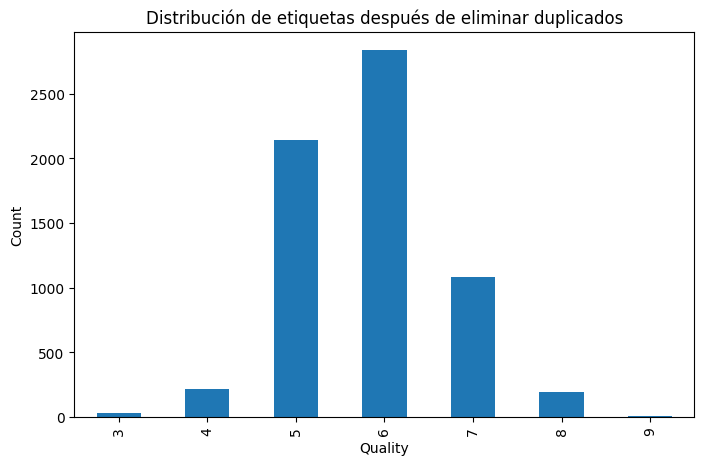

Total de registros por clase:
quality
3      30
4     216
5    2138
6    2836
7    1079
8     193
9       5
Name: count, dtype: int64


In [149]:
plt.figure(figsize=(8, 5))
data_copy_resized['quality'].value_counts().sort_index().plot(kind='bar')
plt.xlabel("Quality")
plt.ylabel("Count")
plt.title("Distribución de etiquetas después de eliminar duplicados")
plt.show()

class_counts = data_copy_resized["quality"].value_counts().sort_index() #contamos la cantidad de registros por cada clase
# Mostrar el conteo en la consola
print("Total de registros por clase:")
print(class_counts)

Como podemos observar en las tablas anteriores podemos concluir lo siguiente:
- Hay un desbalance de clases bastante fuerte, ya que las que tienen más representación en el conjunto de datos son la 5 con 2138 registros, 6 con 2836 y 7 con 1079
- Según la documentación las clasificaciones pueden ir desde 1 a 10, pero no hay registros con clasificación 1, 2 o 10, lo cual va a volver demasiado complicado llegar a clasificar bajo estas etiquetas
- Este desbalance de clases va a significar una complicación para el aprendizaje del modelo debido a que este va a tender a tener sesgos entre las clases mayoritarias y minoritarias

Con este primer acercamiento comenzamos separando el conjunto de entrenamiento y test en una proporción de 80 - 20 siendo entrenamiento y test respectivamente

In [150]:
X = data_copy_resized.drop(columns = ["quality"]) #creamos variable con las variables independientes, drop de la variable objetivo
y = data_copy_resized["quality"] #creamos variable y que sería la objetivo unicamente

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify= y, random_state= 42) #separación de conjunto prueba y test

Una vez separado el conjunto de datos, se procede a crear un balanceador para poder equilibrar las clases, en este caso, se decide implementar un balanceador de SMOTE con estrategia "not Majority" para evitar que favorezca la clase mayoritaria y se centre en las menores, adicionalmente, para este ejercicio se va a optar por hacer dos versiones:
- Primera version con el conjunto de datos balanceados 
- Segunda version con el conjunto de datos SIN balancear

Esto con el fin de analizar que metodología obtiene mejores resultados

In [151]:
smote = SMOTE(sampling_strategy= "not majority", k_neighbors= 3, random_state= 42) #creación del balanceador SMOTE 
X_train_sampled, y_train_sampled = smote.fit_resample(X_train, y_train) #creación de los nuevos conjuntos balanceados
print(y_train_sampled.value_counts()) #mostramos los nuevos valores


quality
5    2269
7    2269
6    2269
8    2269
3    2269
4    2269
9    2269
Name: count, dtype: int64


Una vez tenemos los dos conjuntos de datos (balanceados, sin balancear) se procede a evaluar la estrategía para abordar la situación problema. 

Para este problema se van a implementar tres diferentes modelos a los cuales se les va a hacer una búsqueda de hiperparámetros, estos modelos son:
- RandomForest
- XGBoost
- SVM 

Partiendo de esta idea empezamos creando las listas de parámetros para cada uno 

In [152]:
#HIPERPARAMETROS PARA BUSQUEDA

#Random Forest
param_list_rf = {
    "model__n_estimators": randint(50, 150),
    "model__max_depth": randint(3, 20),
    "model__class_weight": ["balanced"],
    "model__min_samples_split": randint(2, 15)
}
#XGBoost
param_list_xbg = {
    "model__n_estimators": randint(50, 200),
    "model__max_depth": randint(3, 5),
    "model__learning_rate": uniform(0.01, 0.2),
    "model__reg_alpha": [0, 0.1, 0.5, 0.7],  
    "model__reg_lambda": [0, 0.1, 0.5, 0.7]
}
#SVM
param_list_svm = {
    "model__C": uniform(0.1, 10),
    "model__gamma": ["scale"],
    "model__class_weight": ["balanced", None],
    "model__kernel": ["linear", "rbf"]
}

Ahora se procede a crear el pipeline de cada uno para esto se tiene en cuenta lo siguiente:
- RandomForest: se implementa RandomForestClassifier como clasificador
- XGBoost: Este necesita una normalización, después de varias pruebas se opta por un RobustScaler() para controlar de manera más resistente los outliers dado el desbalance, también se utiliza un XGBClassifier con eval_metric "mlogloss"
- SVM: Este también necesita una normalización y después de pruebas se opta también por un RobustScaler() por las mismas razones, para este caso se usa un SVC con kernel linear y C 1.0 para tratar de evitar overfitting

In [153]:
#DEFINICION DE PIPELINES PARA BUSQUEDA
#RandomForest
rf_pipeline = Pipeline([
    ("model", RandomForestClassifier(random_state = 42))
])
#XGBoost
xgb_pipeline = Pipeline([
    ("scaler", RobustScaler()),
    ("model", XGBClassifier(eval_metric = "mlogloss"))
])
#SVM
svm_pipeline = Pipeline([
    ("scaler", RobustScaler()),
    ("model", SVC(kernel= "linear",C = 1.0, probability= True))
])

Dado que se tienen dos conjuntos de datos, balanceados, desbalanceados y se quiere hacer una validación cruzada para encontrar se decide crear una función que recibe por parametro de entrada lo siguiente:
- pipeline: se refiere al pipeline del modelo a ejecutar
- param_list: son los parametros del modelo al que se le va a hacer la validación cruzada
- X: conjunto de entrenamiento, este puede ser balanceado o sin balancear
- y: etiquetas de entrenamiento, este puede ser balanceado o sin balancear
- name: el nombre del modelo el cual se le va a hacer la validación cruzada y posterior entrenamiento

Adicionalmente, se va a encontrar una condición la cual se ejecuta únicamente para el modelo XGBoost el cual organiza el rango de las etiquetas de 0 a 9, ya que este es un modelo iterativo y al no tener registros con clasificaciones 1 o 2 recibe solamente de 3 a 9 lo que lo hace fallar

In [154]:
def search_best_params(pipeline, param_list, X, y, name):
    global class_mapping
    if name in["XGBoost Sampled Train", "XGBoost Train"]:
        unique_classes = np.sort(y.unique())  
        class_mapping = {old_label: new_label for new_label, old_label in enumerate(unique_classes)}
        y = y.map(class_mapping)
     
    search = RandomizedSearchCV(pipeline, param_list, n_iter = 10, cv = 3, scoring="accuracy", random_state=42, n_jobs= -1) #se hace la validación cruzada dependiendo el modelo
    search.fit(X,y) #Ejecutamos el entrenamiento
    print(f"\nMejores hiperparametros para {name}:")
    print(search.best_params_) #imprimimos los mejores parámetros
    best_score = search.best_score_
    print(f"Mejor Accuracy: {search.best_score_:.4f}") #imprimimos el mejor accuracy encontrado por la validación cruzada 
    print(f"Reporte de clasificacion para modelo {name}: \n{classification_report(search.predict(X), y, digits= 4, zero_division=0)}") #mostramos un reporte que permite evaluar la precision por etiqueta, recall, f1 y support

    return search.best_estimator_, best_score, name, class_mapping if name in ["XGBoost Sampled Train", "XGBoost Train"] else None

Una vez definida dicha función, se procede a hacer los entrenamientos e inspección de cada modelo con balance y sus respectivos parámetros, este guarda diferentes valores en diferentes variables las cuales son:
- Primera: guarda el mejor estimador
- Segundo: guarda el mejor score
- Tercero: guarda el nombre del modelo el cual ejecutó la función
- Cuarto: este aplica únicamente para XGboost, ya que necesita un mapeo de las clases para poder visualizarlo bien dado el ajuste de las etiquetas

Tenga en cuenta que son tres modelos con balance por ende la función es invocada tres veces 

In [155]:
print("\n Evaluando modelos en datos Sampled: ")
best_rf_resampled, best_score_rf_sampled, name_rf_sampled, _ = search_best_params(rf_pipeline, param_list_rf, X_train_sampled, y_train_sampled, "Random Forest Sampled Train")
best_xgb_resampled, best_score_xgb_sampled, name_xgb_sampled, xgb_class_mapping_resample = search_best_params(xgb_pipeline, param_list_xbg, X_train_sampled, y_train_sampled, "XGBoost Sampled Train")
best_svm_resampled, best_score_svm_sampled, name_svm_sampled, _ = search_best_params(svm_pipeline, param_list_svm, X_train_sampled, y_train_sampled, "SVM Sampled Train")



 Evaluando modelos en datos Sampled: 

Mejores hiperparametros para Random Forest Sampled Train:
{'model__class_weight': 'balanced', 'model__max_depth': 17, 'model__min_samples_split': 12, 'model__n_estimators': 121}
Mejor Accuracy: 0.8564
Reporte de clasificacion para modelo Random Forest Sampled Train: 
              precision    recall  f1-score   support

           3     1.0000    0.9996    0.9998      2270
           4     0.9969    0.9780    0.9873      2313
           5     0.9471    0.9235    0.9352      2327
           6     0.9039    0.9571    0.9297      2143
           7     0.9758    0.9702    0.9730      2282
           8     0.9991    0.9947    0.9969      2279
           9     1.0000    1.0000    1.0000      2269

    accuracy                         0.9747     15883
   macro avg     0.9747    0.9747    0.9746     15883
weighted avg     0.9752    0.9747    0.9748     15883


Mejores hiperparametros para XGBoost Sampled Train:
{'model__learning_rate': np.float64(0.1764

En los valores anteriores se pueden observar los mejores parámetros, el mejor accuracy y un reporte basádo en los datos de entrenamiento, a primera instancia aparentemente este entrenamiento con los datos balanceados tiene unos resultados bastante positivos dado que tenemos accuracy mayores a 73% hasta 97%. 

Ahora se procede a hacer el mismo ejercicio pero ahora invocando la función con los datos sin balancear, es decir los mismos tres modelos pero con datos de entrenamiento sin balancear.

In [156]:
print("\n Evaluando modelos en datos sin Sampled: ")
best_rf, best_score_rf, name_rf, _ = search_best_params(rf_pipeline, param_list_rf, X_train, y_train, "Random Forest Train ")
best_xgb, best_score_xgb, name_xgb, xgb_class_mapping = search_best_params(xgb_pipeline, param_list_xbg, X_train, y_train, "XGBoost Train")
best_svm, best_score_svm, name_svm,_ = search_best_params(svm_pipeline, param_list_svm, X_train, y_train, "SVM Train")


 Evaluando modelos en datos sin Sampled: 

Mejores hiperparametros para Random Forest Train :
{'model__class_weight': 'balanced', 'model__max_depth': 17, 'model__min_samples_split': 12, 'model__n_estimators': 121}
Mejor Accuracy: 0.6217
Reporte de clasificacion para modelo Random Forest Train : 
              precision    recall  f1-score   support

           3     1.0000    0.9231    0.9600        26
           4     1.0000    0.9105    0.9532       190
           5     0.9117    0.8878    0.8996      1756
           6     0.8726    0.9429    0.9064      2100
           7     0.9710    0.8784    0.9224       954
           8     1.0000    0.9222    0.9595       167
           9     1.0000    1.0000    1.0000         4

    accuracy                         0.9105      5197
   macro avg     0.9651    0.9235    0.9430      5197
weighted avg     0.9134    0.9105    0.9108      5197


Mejores hiperparametros para XGBoost Train:
{'model__learning_rate': np.float64(0.17648852816008437), 'm

Como podemos observar los accuracy para los modelos desbalanceados son significativamente menores, ya que están entre 57% y 62% lo cual indicaría que los modelos no son tan eficientes a comparación de los modelos con datos balanceados, este tiende a fallar más en clases minoritarias mientras que con clases balanceadas este identifica casi todas sin problema

Ahora procedemos a hacer la evaluación de los modelos entrenados previamente con el conjunto test, para este caso se opta por crear una funcion que recibe:
- model: mejor modelo entrenado
- X_test: datos de prueba
- y_test: etiquetas de test para comparar después
- class_mapping: solo aplica para XGBoost porque tiene que hacer el proceso inverso de las etiquetas para dejarlas como originalmente estaban

Adicionalmente, se va a encontrar con una condicional que como se mencionó anteriormente solo aplica para XGBoost, ya que aplica el proceso inverso a las etiquetas.
Finalmente, este hace las predicciones, muestra un reporte con los accuracy, f1, recall y support y devuelve dos variables:
- name: nombre del modelo evaluado
- acc: se refiere al accuracy logrado

Estas dos se almacenan para más adelante comparar con el set de prueba  

In [157]:
def evaluate_model(model, X_test, y_test, name, class_mapping = None):
    y_pred = model.predict(X_test)
    
    if class_mapping:
        reverse_mapping = {v: k for k, v in class_mapping.items()}
        y_pred = np.vectorize(reverse_mapping.get)(y_pred)
    acc = accuracy_score(y_test, y_pred)
    print(f"Reporte de clasificacion para modelo {name}: \n{classification_report(y_test, y_pred, digits= 4, zero_division=0)}")
    return name, acc

Ejecutamos las pruebas por cada uno de los modelos preentrenados, pasando por parametro sus respectivos valores y el conjunto de test

In [158]:
results_test = []
results_test.append(evaluate_model(best_rf_resampled, X_test, y_test, "random forest sampled"))
results_test.append(evaluate_model(best_xgb_resampled, X_test, y_test, "XGBoost sampled", xgb_class_mapping_resample))
results_test.append(evaluate_model(best_svm_resampled, X_test, y_test, "SVM Sampled"))

Reporte de clasificacion para modelo random forest sampled: 
              precision    recall  f1-score   support

           3     0.0000    0.0000    0.0000         6
           4     0.2031    0.3023    0.2430        43
           5     0.6682    0.6729    0.6705       428
           6     0.7050    0.5732    0.6323       567
           7     0.5086    0.6852    0.5838       216
           8     0.3333    0.4103    0.3678        39
           9     0.0000    0.0000    0.0000         1

    accuracy                         0.6077      1300
   macro avg     0.3455    0.3777    0.3568      1300
weighted avg     0.6287    0.6077    0.6126      1300

Reporte de clasificacion para modelo XGBoost sampled: 
              precision    recall  f1-score   support

           3     0.0000    0.0000    0.0000         6
           4     0.1714    0.2791    0.2124        43
           5     0.6533    0.6075    0.6295       428
           6     0.6378    0.5714    0.6028       567
           7    

Como puede observar, la prueba Test para el modelo preentrenado con datos balanceados presenta una caída significativa en su accuracy, ya que está entre 49% y 60%, más adelante se comparan todos, pero esto es un primer acercamiento sobre el comportamiento de los modelos balanceados.

Procedemos ahora a hacer lo mismo para los modelos preentrenados con datos NO balanceados.

In [159]:
results_test.append(evaluate_model(best_rf, X_test, y_test, "random forest"))
results_test.append(evaluate_model(best_xgb, X_test, y_test, "XGBoost",  xgb_class_mapping))
results_test.append(evaluate_model(best_svm, X_test, y_test, "SVM"))

Reporte de clasificacion para modelo random forest: 
              precision    recall  f1-score   support

           3     0.0000    0.0000    0.0000         6
           4     0.2667    0.1860    0.2192        43
           5     0.6726    0.7009    0.6865       428
           6     0.6705    0.6102    0.6390       567
           7     0.5197    0.6713    0.5859       216
           8     0.5556    0.3846    0.4545        39
           9     0.0000    0.0000    0.0000         1

    accuracy                         0.6262      1300
   macro avg     0.3836    0.3647    0.3693      1300
weighted avg     0.6258    0.6262    0.6229      1300

Reporte de clasificacion para modelo XGBoost: 
              precision    recall  f1-score   support

           3     0.0000    0.0000    0.0000         6
           4     0.2857    0.0930    0.1404        43
           5     0.6944    0.6636    0.6786       428
           6     0.6263    0.7478    0.6817       567
           7     0.6304    0.537

Como podemos observar en este caso los valores de los accuracy tienden a mantenerse, si bien varían un poco este permanece entre 58% y 64% incluso se puede notar que hubo un caso donde se desempeñó mejor en test que en entrenamiento, pero más adelante se mostrará la comparativa entre test y entrenamiento, pero esto nos da un primer indicio frente al comportamiento de los modelos no balanceados

Ahora extraemos todos los accuracy tanto balanceados como desbalanceados y se unen en dos grupos los cuales son Test y entrenamiento esto con el fin de sacar conclusiones de cada modelo

In [163]:
df_results = pd.DataFrame(results_test, columns = ["modelo", "accuracy"])
df_results = df_results.sort_values(by = "accuracy", ascending=False).reset_index(drop= True)
print(f"Comparacion de Accuracy entre Modelos en Test: \n{df_results}")
results_train = []
results_train.append((name_rf, best_score_rf))
results_train.append((name_xgb, best_score_xgb))
results_train.append((name_svm, best_score_svm))
results_train.append((name_rf_sampled, best_score_rf_sampled))
results_train.append((name_xgb_sampled, best_score_xgb_sampled))
results_train.append((name_svm_sampled, best_score_svm_sampled))
df_results_train = pd.DataFrame(results_train, columns = ["modelo", "accuracy"])
df_results_train = df_results_train.sort_values(by = "accuracy", ascending=False).reset_index(drop= True)
print(f"Comparacion de Accuracy entre Modelos en Train: \n{df_results_train}")

Comparacion de Accuracy entre Modelos en Test: 
                  modelo  accuracy
0                XGBoost  0.647692
1          random forest  0.626154
2  random forest sampled  0.607692
3                    SVM  0.587692
4        XGBoost sampled  0.567692
5            SVM Sampled  0.495385
Comparacion de Accuracy entre Modelos en Train: 
                        modelo  accuracy
0  Random Forest Sampled Train  0.856388
1        XGBoost Sampled Train  0.830072
2            SVM Sampled Train  0.777877
3         Random Forest Train   0.621709
4                XGBoost Train  0.614204
5                    SVM Train  0.579567


CONCLUSIONES
- El mejor modelo para este caso es el modelo de XGBoost el cual muestra un accuracy de 64% en el conjunto de test y un 61% en el conjunto de prueba
- los modelos con el balanceo de datos muestran un excelente desempeño en entrenamiento, pero una baja bastante significativa en el conjunto de test (aproximadamente entre 20 a 40% menos), esto indica que hay un sobre entrenamiento en los modelos preentrenados con datos balanceados, esto se puede deber a que el desbalance al ser tan grande, generar datos sintéticos se vuelve contraproducente para el modelo, pues este no es capar de generalizar de manera efectiva.
- Los modelos sin el balanceo de datos pese a tener un menor desempeño en entrenamiento, muestran una mayor consistencia e incluso desempeño al momento de hacer predicciones esto demuestra que no hay un sobre entrenamiento lo cual da mayor confiabilidad frente al modelo y sus resultados.
- Los modelos sin balanceo son muy buenos para detectar clases mayoritarias como 5, 6 o 7, sin embargo, no son tan efectivas para las demás, por otro lado, este sesgo no fue posible de evitar dado que el desbalance de los datos era bastante contundente luego para el modelo lograr hallar un patron para identificar dichas clases era mucho más complicado que para las clases mayoritarias, pero aun así su capacidad de generalizar es muy buena, pues concuerdan los dos conjuntos en sus porcentajes.
- Al final se decide no eliminar los datos duplicados porque si bien estos datos pueden generar problemas al momento de un aprendizaje para este caso en específico eliminarlos afectaban clases minoritarias haciendo que su generalización disminuyera aún más, incluyendo la precision y aumentando el sesgo entre las clases con mayor cantidad de registros frente a las que no, y este impacto se evidenciaba tanto para los datos balanceados como sin balancear, ambos su rendimiento disminuía significativamente.
- En este caso los datos duplicados podrían ayudar a una regularización implícita dado que XGBoost y SVM son sensibles al número de ejemplos por clase, entonces estos duplicados pudieron ayudar a suavizar fronteras de decisión
- de manera general se sabe que el modelo a futuro necesitará reentrenarse para poder mejorar la clasificación para clases minoritarias, actualmente tiene 64% de precision y es efectivo para las clases 5, 6 y 7, pero para poder ampliar la clasificación y mejorarlo se necesita una mayor cantidad de registros con las demás etiquetas para poder ampliar la capacidad del modelo para identificar patrones dentro de estas clasificaciones sin la necesidad de generar balanceos pesados que pueden llevarlo a sobre ajustes y pueda identificarlas muchísimo mejor y así eliminar este sesgo.